## Check limit classically

In [1]:
import json
fiel_new_vectors = "new_noun_vectors.json"
with open(fiel_new_vectors, 'r') as fp:
    new_noun_vectors = json.load(fp)

In [2]:
# start with file, register, smooth
import numpy as np
from words import sentences as sentences


triplets = [
    ["register", "smooth"],
    ["drip", "carry"],
    ["knock", "intercept"],
    ["bill", "accuse"]
]

verb_vectors = {}
true_sentences = {}
for triplet in triplets:

    
    nouns, verbs = set(), set()
    for sentence in sentences:
        _s = sentence.split(" ")
        if _s[0] in triplet:
            true_sentences[(_s[0],_s[1])] = int(_s[2][1])
            verbs.add(_s[0])
            nouns.add(_s[1])

    n_verbs = len(verbs)
    noun_list = list(nouns)
    verb_list = list(verbs)
    all_combinations = [(verb, noun) for verb in verb_list for noun in noun_list]
    plausabilities = [true_sentences.get(sent,0) for sent in all_combinations]
    S = np.array(plausabilities).reshape((n_verbs,len(nouns)))
    N = np.array([new_noun_vectors[noun] for noun in noun_list]).transpose()

    N_inv = np.linalg.pinv(N)
    V = np.dot(S,N_inv)
    v_calc = {verb: V[i]/np.linalg.norm(V[i]) for i,verb in enumerate(verbs)}
    verb_vectors = {**verb_vectors, **v_calc}

In [3]:
verb_vectors

{'register': array([-0.57859256,  0.50741707, -0.63811846,  0.02373601]),
 'smooth': array([ 0.18083686,  0.81856903, -0.536361  , -0.09777349]),
 'drip': array([ 0.43100218,  0.105271  , -0.49622952,  0.74626497]),
 'carry': array([ 0.58359099, -0.12186328, -0.04324822, -0.80168603]),
 'intercept': array([-0.28297369, -0.6653991 , -0.68762426, -0.06589991]),
 'knock': array([ 0.85631379, -0.22077113, -0.42251512, -0.19866502]),
 'bill': array([-0.67165941, -0.63748791,  0.32928983, -0.18452913]),
 'accuse': array([-0.4054801 ,  0.77792403, -0.13044508, -0.46195691])}

In [4]:
loss = []
for sentence in sentences:
    _s = sentence.split(" ")
    true_result = int(_s[2][1])
    try:
        calc_result = np.abs(np.dot(new_noun_vectors[_s[1]],verb_vectors[_s[0]]))
        loss.append((true_result-calc_result)**2)
    except:
        pass
mse = np.mean(loss)
print("Baseline: ", mse)

Baseline:  0.07233522757659573


In [5]:
folder = "experiments/density_matrix_model"
evo_path = os.path.join(folder,"evo.json")
with open(evo_path) as json_file:
    evo = json.load(json_file)

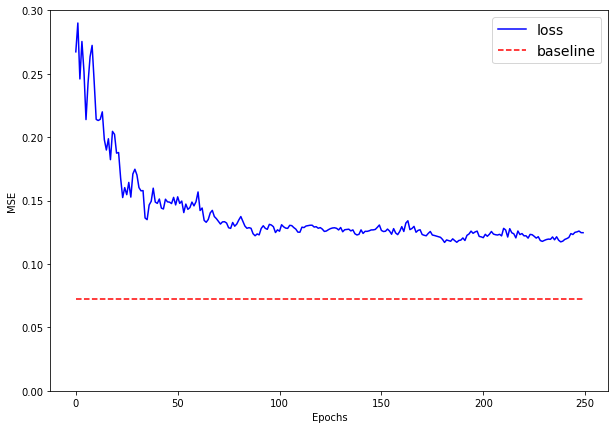

In [6]:
import matplotlib.pyplot as plt

dims = (10,7)
fig, ax = plt.subplots(figsize=dims)
plt.rcParams["font.size"] = "14"
plt.plot(range(len(evo)), evo, '-b', label='loss')
plt.plot(range(len(evo)), [mse]*len(evo), '--r', label='baseline')
plt.ylim([0,0.3])
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(loc='upper right')
#plt.title("temp")
plt.savefig("../report/figure/results/spsa_density_matrix_fit.pdf")

## Calculate density matrices from quantum fits

In [7]:
# load the best fit
with open(os.path.join(folder,"params.json"), 'r') as fp:
    quantum_params = json.load(fp)
print(quantum_params["register"])

{'p': [0.5952880307102117, 0.9639360097153454, 0.6336371774276015, 0.8755335714046495, 0.28521670010034494, 0.12898488095311456], 'learn': True}


In [8]:
# load the quantum ansätze
from discopy.quantum import CX, Circuit, CRz, H, Ket, Rx, Rz, Ry, X, sqrt, C, SWAP, CRy, Bra
n_verb_params = 6


def verb_ansatz(p):
    return Ket(0,0) >> \
        Rx(p[0]) @ Rx(p[1]) >> \
        Ry(p[2]) @ Ry(p[3]) >> \
        Rz(p[4]) @ Rz(p[5]) >> \
        CX >> SWAP >> CX >> SWAP 
        
def noun_ansatz(arr):
    a1 = np.linalg.norm(arr[0:2])
    a2 = np.linalg.norm(arr[2:])
    phi1 = np.arccos(a1)/np.pi

    # fix issues with rotations
    rot1 = arr[0:2]/a1
    phi2_cos = np.arccos(rot1[0])/np.pi
    phi2_sin = np.arcsin(rot1[1])/np.pi
    if not np.sign(phi2_cos) == np.sign(phi2_sin):
        phi2_cos *= -1
    rot2 = arr[2: ]/a2
    phi3_cos = np.arccos(rot2[0])/np.pi
    phi3_sin = np.arcsin(rot2[1])/np.pi
    if not np.sign(phi3_cos) == np.sign(phi3_sin):
        phi3_cos *= -1

    return Ket(0,0) >> Ry(phi1) @ Circuit.id(1) >> CRy(phi3_cos) >> X @ Circuit.id(1) >> CRy(phi2_cos) >> X @ Circuit.id(1)

### start with "file"

In [9]:
## quantum model
verb_states = {verb: verb_ansatz(quantum_params[verb]["p"]).eval().array.flatten() for verb in verb_vectors}
noun_states = {noun: noun_ansatz(quantum_params[noun]["p"]).eval().array.flatten() for noun in new_noun_vectors}

# purely classical model
#verb_states = verb_vectors
#noun_states = new_noun_vectors

In [10]:
#classically calculated loss
loss = []
k=0
for sentence in sentences:
    _s = sentence.split(" ")
    true_result = int(_s[2][1])
    try:
        calc_result = np.abs(np.dot(noun_states[_s[1]],verb_states[_s[0]]))
        #print(sentence)
        #print(calc_result)
        loss.append((true_result-calc_result)**2)
    except:
        pass
    
mse = np.mean(loss)
#print(loss)
print("Classically calc MSE: ", mse)

Classically calc MSE:  0.10053607154709776


In [11]:
verb = verb_states["smooth"]
noun = noun_states["tooth"]
np.abs(np.dot(verb,noun))**2

0.9022355153746857

In [12]:
rho_file = 1/2 * np.outer(np.conj(verb_states["register"]),verb_states["register"]) + \
    1/2 * np.outer(np.conj(verb_states["smooth"]),verb_states["smooth"])
print(rho_file.round(3))

[[ 0.439+0.j     0.052+0.112j  0.024-0.034j -0.152-0.079j]
 [ 0.052-0.112j  0.446+0.j    -0.128-0.059j -0.019+0.048j]
 [ 0.024+0.034j -0.128+0.059j  0.046+0.j    -0.01 -0.019j]
 [-0.152+0.079j -0.019-0.048j -0.01 +0.019j  0.069+0.j   ]]


In [13]:
from scipy.linalg import logm
def von_neumann_entropy(rho):
    return np.abs(np.trace(np.dot(rho, logm(rho))))

von_neumann_entropy(rho_file)

0.6553790517603129

In [14]:
rho_account = np.outer(np.conj(noun_states["account"]),noun_states["account"])
von_neumann_entropy(rho_account).round(5)
von_neumann_entropy(np.multiply(rho_account,rho_file))

0.4842888128809583

In [15]:
from words import noun_groups, pairs
from pprint import pprint

s_dict = {}
disamb = []
disamb_rand = []
for amb_verb in pairs:
    sense1, sense2 = pairs[amb_verb]
    rho = 1/2 * np.outer(verb_states[sense1],np.conj(verb_states[sense1])) + \
        1/2 * np.outer(verb_states[sense2],np.conj(verb_states[sense2]))
    s = von_neumann_entropy(rho)
    s_dict[amb_verb] = {"init": s, "disamb": {}, "rand": []}

    for noun in noun_groups[amb_verb]:
        rho_n = np.outer(noun_states[noun],np.conj(noun_states[noun]))
        rho_comp = np.multiply(rho_n,rho)
        rho_comp /= np.trace(rho_comp)
        s_comp = von_neumann_entropy(rho_comp)
        s_dict[amb_verb]["disamb"][noun] = s_comp
        disamb.append((s-s_comp)/s)

        i=0
        while i<10:
            # per word get some random vectors for disambiguation
            z = np.random.uniform(-1,1,size=(4,))#.view(np.complex128)
            z /= np.linalg.norm(z)

            l = []
            for noun in noun_groups[amb_verb]:
                l.append(np.abs(np.dot(z,noun_states[noun])))
            if any(i >= 0.7 for i in l):
                continue
            i+=1
            rho_rand = np.outer(z,np.conj(z))
            rho_comp_rand = np.multiply(rho_rand,rho)
            rho_comp_rand /= np.trace(rho_comp_rand)
            s_comp_rand = von_neumann_entropy(rho_comp_rand)
            s_dict[amb_verb]["rand"].append(von_neumann_entropy(rho_comp_rand))
            disamb_rand.append((s-s_comp_rand)/s)

pprint(s_dict)

/home/thomas/Studies/CAS/4th_semester/Masterthesis/code/venv/lib/python3.8/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)
/home/thomas/Studies/CAS/4th_semester/Masterthesis/code/venv/lib/python3.8/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)
{'charge': {'disamb': {'commission': 0.6387282953882493,
                       'defendant': 0.20679352162472575,
                       'demonstrator': 0.347015699397714,
                       'fee': 0.566807660472952,
                       'interest': 0.36252428754810573,
                       'offender': 0.3037025826922915,
                       'person': 0.31494175987588435,
                       'price': 0.05879063182088217,
                       'rate'

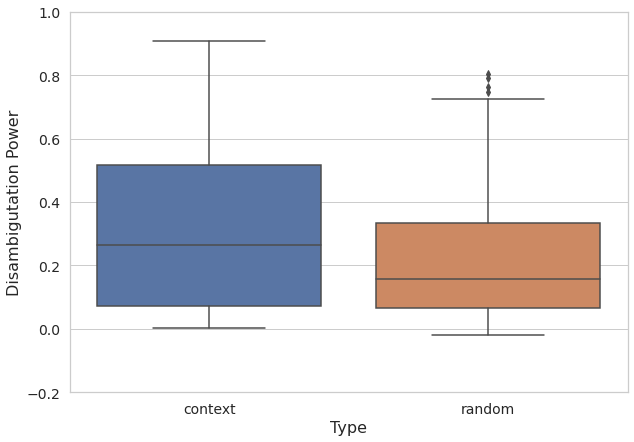

In [16]:
import seaborn as sns
import pandas as pd
sns.set_theme(style="whitegrid")
# create boxplots
n_list = ["context" for i in range(len(disamb))]
r_list = ["random" for i in range(len(disamb_rand))]
data = pd.DataFrame({"Disambigutation Power": disamb+disamb_rand, "type": n_list+r_list})

dims = (10,7)
fig, ax = plt.subplots(figsize=dims)
b = sns.boxplot(ax=ax, x="type", y="Disambigutation Power", data=data)
b.tick_params(labelsize=14)
b.set_xlabel("Type",fontsize=16)
b.set_ylabel("Disambigutation Power",fontsize=16)
ax.set(ylim=(-0.2, 1));  

In [17]:
print(np.median(disamb))
print(np.median(disamb_rand))
print(len(n_list))
print(len(r_list))

0.26432457938813997
0.157720395969745
35
350


In [18]:
from scipy.stats import ranksums

ranksums(disamb,disamb_rand)

RanksumsResult(statistic=1.454453040504898, pvalue=0.1458207437985194)

## Similarity measure of disambiguated verbs

In [23]:
from words import noun_groups, pairs
from pprint import pprint
import pandas as pd

save = {"word": [], "similarity": [], "score": []}
results = {amb_verb: [] for amb_verb in pairs}
for amb_verb in pairs:
    # construct density matrix of ambigious verb
    sense1, sense2 = pairs[amb_verb]
    rho = 1/2 * np.outer(verb_states[sense1],np.conj(verb_states[sense1])) + \
        1/2 * np.outer(verb_states[sense2],np.conj(verb_states[sense2]))

    for noun in noun_groups[amb_verb]:
        rho_n = np.outer(noun_states[noun],np.conj(noun_states[noun]))
        rho_comp = np.multiply(rho_n,rho)
        rho_comp /= np.trace(rho_comp)

        # calculate similarity to random word
        z = np.random.uniform(-1,1,size=(4,))
        z /= np.linalg.norm(z)
        rho_rand = np.matrix(np.outer(z,np.conj(z)))
        rho_comp_rand = np.multiply(rho_rand,rho)
        rho_comp_rand /= np.trace(rho_comp_rand)

        max_rand_sim = 0
        for sense in pairs[amb_verb]:

            rho_sense = np.matrix(np.outer(verb_states[sense],np.conj(verb_states[sense])))
            similarity = np.abs(np.trace(np.dot(rho_sense.getH(),rho_comp)))
            gtruth = true_sentences.get((sense,noun),0)
            
            save["word"].append(amb_verb)

            if gtruth == 0:
                save["similarity"].append("context")
                save["score"].append(1-similarity)
                results[amb_verb].append([gtruth, similarity])
            else:
                save["similarity"].append("context")
                save["score"].append(similarity)
                results[amb_verb].append([gtruth, similarity])

            similarity_rand = np.abs(np.trace(np.dot(rho_sense.getH(),rho_comp_rand)))
            max_rand_sim = max(max_rand_sim,similarity_rand)

        save["word"].append(amb_verb)
        save["similarity"].append("random")
        save["score"].append(max_rand_sim)
            
save_df = pd.DataFrame.from_dict(save)
save_df.head(15)

,word,similarity,score
0,file,context,0.555220
1,file,context,0.719944
2,file,random,0.526431
3,file,context,0.556273
4,file,context,0.509182
5,file,random,0.645026
6,file,context,0.652972
7,file,context,0.743470
8,file,random,0.294760
9,file,context,0.612360


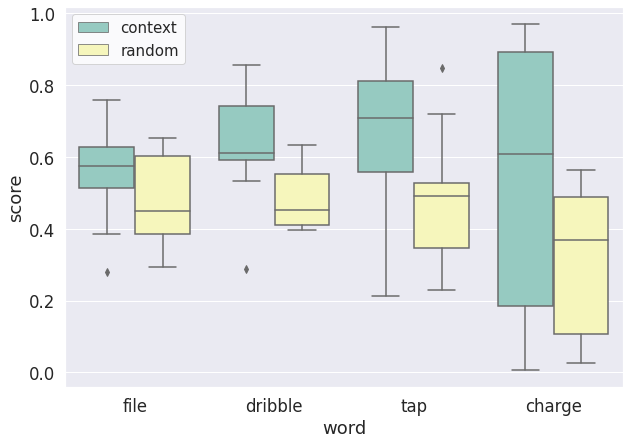

In [24]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(font_scale=1.5)
dims = (10,7)
fig, ax = plt.subplots(figsize=dims)


sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
sns.boxplot(ax=ax, x="word", y="score", hue="similarity",
                 data=save_df, palette="Set3")
plt.legend(prop={"size":15});

In [25]:
# check for difference in distribution
for amb_verb in results:
    idx1 = (save_df.word == amb_verb) & (save_df.similarity=="context")
    idx2 = (save_df.word == amb_verb) & (save_df.similarity=="random")
    print(amb_verb,ranksums(save_df[idx1].score,save_df[idx2].score))

file RanksumsResult(statistic=1.3372956996714631, pvalue=0.18112613415641965)
dribble RanksumsResult(statistic=2.060488785479727, pvalue=0.039351836861343546)
tap RanksumsResult(statistic=2.287694994333111, pvalue=0.02215528941837963)
charge RanksumsResult(statistic=1.5837888422306154, pvalue=0.11324177925260663)
